# Problema de negocio

A indústria de táxis está evoluindo rapidamente. Novos concorrentes e tecnologias estão mudando a forma como os serviços de táxi tradicionais fazem negócios. Embora esta evolução tenha criado novas eficiências, também criou novos problemas.

Uma mudança importante é a adoção generalizada de sistemas de despacho eletrônico que substituíram os sistemas de despacho de rádio VHF de tempos passados. Esses terminais móveis de dados são instalados em cada veículo e normalmente fornecem informações sobre localização GPS e estado do taxímetro. Os sistemas de despacho eletrônico facilitam a visualização de onde um táxi esteve, mas não necessariamente para onde está indo. Na maioria dos casos, os taxistas que operam com sistema de despacho eletrônico não indicam o destino final da viagem atual.

Outra mudança recente é a mudança de mensagens de rádio baseadas em transmissão (um para muitos) para despacho de serviço para mensagens baseadas em unicast (um para um). Com mensagens unicast, o despachante precisa identificar corretamente qual táxi deve despachar para o local de coleta. Como os táxis que utilizam sistemas de despacho eletrônico geralmente não entram no local de entrega, é extremamente difícil para os despachantes saber qual táxi contatar.

Para melhorar a eficiência dos sistemas electrónicos de despacho de táxis é importante ser capaz de prever o destino final de um táxi enquanto este está em serviço. Particularmente durante períodos de alta demanda, muitas vezes há um táxi cuja corrida atual terminará próximo ou exatamente no local de retirada solicitado por um novo passageiro. Se um despachante soubesse aproximadamente onde seus motoristas de táxi terminariam suas viagens atuais, ele seria capaz de identificar qual táxi atribuir a cada solicitação de coleta.



Neste desafio, pedimos-lhe que construa uma estrutura preditiva que seja capaz de inferir o destino final das corridas de táxi no Porto, Portugal, com base nas suas trajetórias parciais (iniciais). A saída desse quadro deve ser o destino final da viagem (coordenadas WGS84).

# Descrição dos Dados

TRIP_ID : (String) Contém um identificador único para cada viagem;

CALL_TYPE : (char) Identifica a forma utilizada para demandar este serviço. Pode conter um dos três valores possíveis:

- 'A' se esta viagem foi despachada da central;

- 'B' se esta viagem foi solicitada diretamente a um taxista em ponto específico;

- 'C' caso contrário (ou seja, uma viagem exigida em uma rua aleatória).

ORIGIN_CALL : (inteiro) Contém um identificador único para cada número de telefone que foi utilizado para demandar, pelo menos, um serviço. Identifica o cliente da viagem se CALL_TYPE='A'. Caso
contrário, assume um valor NULL;

ORIGIN_STAND : (inteiro): Contém um identificador único do ponto de táxi. Identifica o ponto inicial da viagem se CALL_TYPE='B'. Caso contrário, assume um valor NULL;

TAXI_ID : (inteiro): Contém um identificador único do taxista que realizou cada viagem;

TIMESTAMP : (inteiro) carimbo de data/hora Unix (em segundos). Identifica o início da viagem;

DAYTYPE : (char) Identifica o tipo de dia de início da viagem. Ele assume um dos três valores possíveis:

- 'B' se esta viagem começou num feriado ou em qualquer outro dia especial (ou seja, feriados prolongados, feriados flutuantes, etc.);

- 'C' se a viagem começou um dia antes de um dia tipo B;

- 'A' caso contrário (ou seja, um dia normal, dia útil ou fim de semana).

MISSING_DATA : (Booleano) É FALSE quando o fluxo de dados GPS está completo e TRUE sempre que um (ou mais) locais estão faltando

POLYLINE : (String): Contém uma lista de coordenadas GPS (ou seja, formato WGS84) mapeadas como uma string. O início e o fim da string são identificados entre colchetes (ou seja, [ e ],
respectivamente). Cada par de coordenadas também é identificado pelos mesmos colchetes que [LONGITUDE, LATITUDE]. Esta lista contém um par de coordenadas para cada 15 segundos de viagem.
O último item da lista corresponde ao destino da viagem enquanto o primeiro representa o seu início;

# 0.0 Imports

In [1]:
import os
import re
import ast
import math
import warnings
import datetime

import pickle
import folium
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
from folium import plugins
from itertools import count
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


## 0.1 Helper Function

In [2]:
def extract_coordinates(df, coord):
    lista=list()
    for i in range(0,len(df["polyline"])):
        if df["polyline"][i] == '[]':
            ax=0

        else:
            ax = df["polyline"][i].split(',')[coord].strip('[]')

        lista.append(ax)

    return lista

def HaversineDistance(lat_sub, lon_sub, lat_real, lon_real):
	REarth=6371
	lat = abs(lat_sub - lat_real) * math.pi / 180
	lon = abs(lon_sub - lon_real) * math.pi / 180
	lat1 = lat_sub * math.pi / 180
	lat2 = lat_real * math.pi / 180
	a = math.sin(lat / 2) * math.sin(lat / 2) + math.cos(lat1) * math.cos(lat2) * math.sin(lon / 2) * math.sin(lon / 2)
	d = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
	distancia = REarth * d

	return distancia

def MeanHaversineDistance(result):
	

	return result.apply(lambda row: HaversineDistance(row['pred_lat'], 
												  row['pred_long'], 
												  row['end_lat'], 
												  row['end_long']), axis=1).mean()

def miss_flg(x):
    
    if x["missing_data"] == False:
        res = 0
    else:
        res = 1
    return res

def fit_model(model, X_train, X_test, y_train, y_test):
    
    model_mult = MultiOutputRegressor(model)
    model_mult = model_mult.fit(X_train, y_train)
    y_train_pred = model_mult.predict(X_train)
    y_test_pred = model_mult.predict(X_test)

    y_train_pred = pd.DataFrame(y_train_pred, columns=['pred_lat', 'pred_long'])

    y_train = y_train.reset_index()
    y_train_pred = y_train_pred.reset_index()

    df_result = pd.concat([y_train, y_train_pred], axis=1)

    result = MeanHaversineDistance(df_result )
    
    name = type(model).__name__
    save_model(model_mult, name)
    
    return pd.DataFrame({'Model Name': name,
                          'Erro testing RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
                          'Erro Teste MSE': mean_squared_error(y_test, y_test_pred),
                          'distance': result

    }, index=[0])

def save_model(model, name):
    home = os.path.dirname(os.getcwd())
    name = name + '.pkl'
    pickle.dump(model, open(os.path.join(home, 'model', name), 'wb'))

def jupyter_settings():
    %matplotlib inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 12
    plt.rcParams["axes.formatter.useoffset"] = False
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

## 0.2 Data load

In [3]:
home = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(home, 'data', 'train.csv'))
df

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


# 1.0 Descrição dos Dados

## 1.1 Dimensão dos dados

In [4]:
print(f'Numeros de linhas:{df.shape[0]} ')
print(f'Numeros de colunas: {df.shape[1]}')

Numeros de linhas:1710670 
Numeros de colunas: 9


## 1.2 Renomear colunas

In [5]:
# Renomear colunas
cols_old = list(df.columns)

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
df.columns = cols_new

In [6]:
df.describe()

,trip_id,origin_call,origin_stand,taxi_id,timestamp
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09


## 1.3 Tipos de dados

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.dtypes

trip_id                  int64
call_type               object
origin_call            float64
origin_stand           float64
taxi_id                  int64
timestamp       datetime64[ns]
day_type                object
missing_data              bool
polyline                object
dtype: object

# 1.4 Check NA

In [8]:
df.isna().sum()

trip_id               0
call_type             0
origin_call     1345900
origin_stand     904091
taxi_id               0
timestamp             0
day_type              0
missing_data          0
polyline              0
dtype: int64

## 1.5 Fillout NA

In [9]:
# Substituir valores NAN por 0
df['origin_call'] = df['origin_call'].fillna(0)
df['origin_stand'] = df['origin_stand'].fillna(0)

## 1.6 Alterar os tipos de dados

In [10]:
df['origin_call'] = df['origin_call'].astype(int)
df['origin_stand'] = df['origin_stand'].astype(int)

# 3.0 Exploratory Data Analysis

In [11]:
# Separarção da variaveis numéricas e categoricas
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

## 3.1 Analise Univariada

### 3.1.1 Variaveis numericas

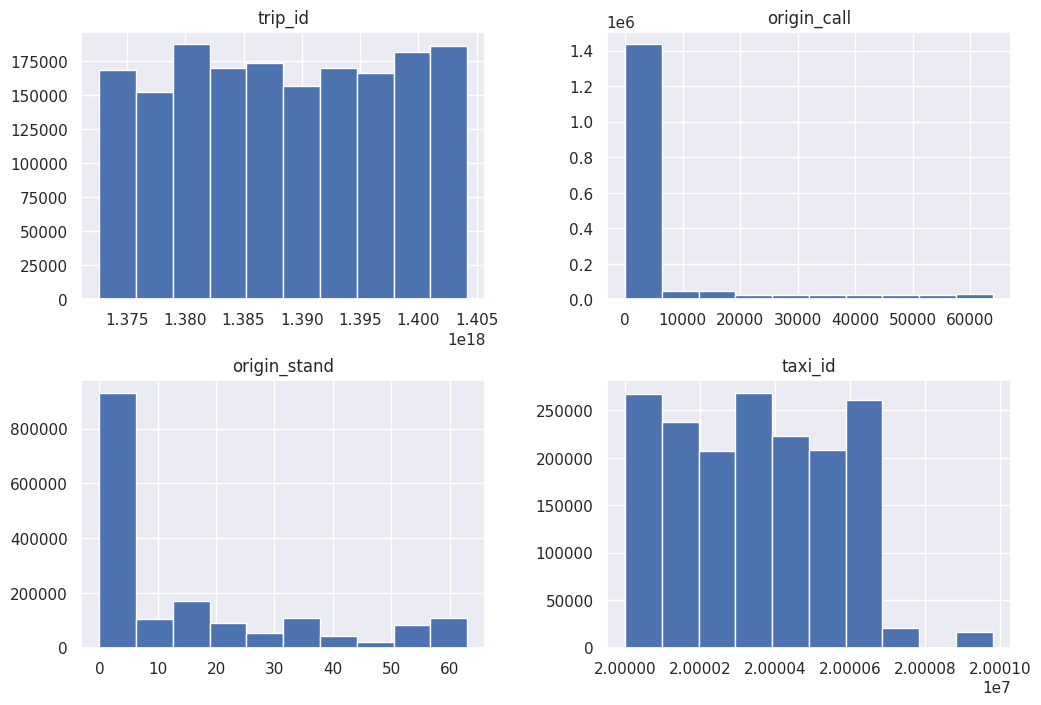

In [12]:
num_attributes.hist();

### 3.1.2 Variaveis Categoricas

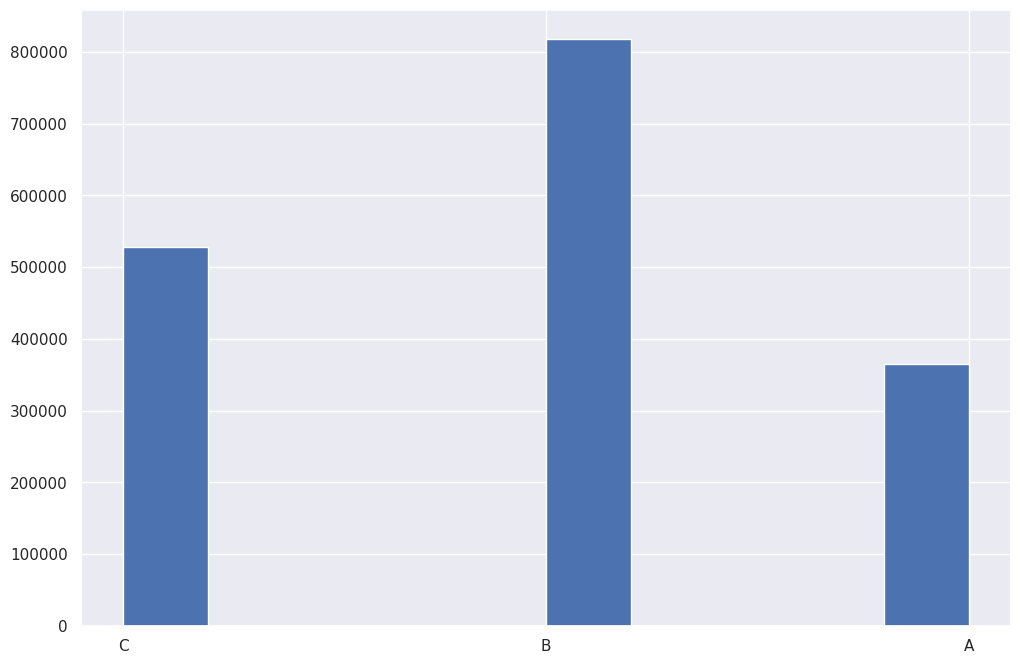

In [13]:
# call_type
cat_attributes['call_type'].hist();

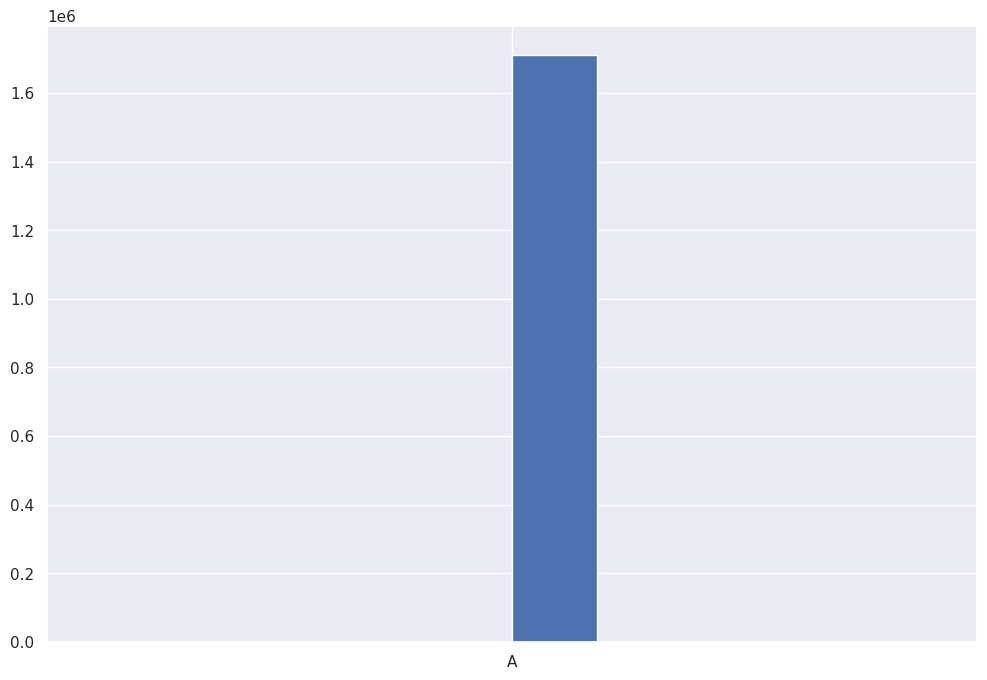

In [14]:
# day_type
cat_attributes['day_type'].hist();

<Axes: xlabel='missing_data', ylabel='count'>

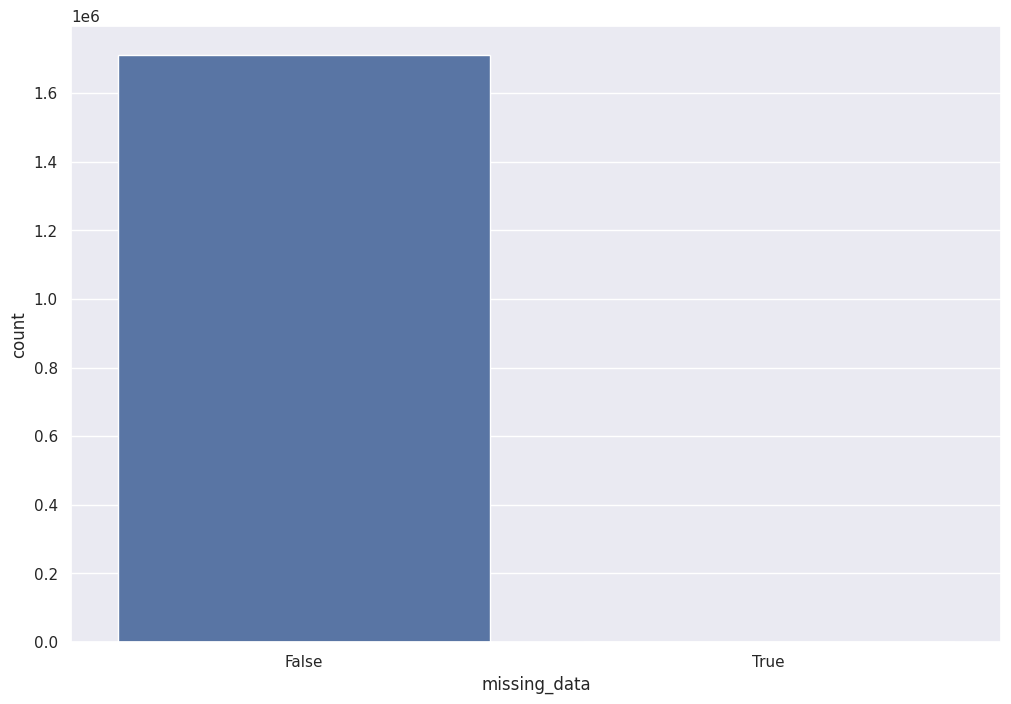

In [15]:
# missing_data
sns.countplot(x='missing_data', data=df)

#### 3.1.2.1 Analise temporal

In [16]:
# Time data preparation
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df["min"] = df["timestamp"].dt.minute
df["weekday"] = df["timestamp"].dt.weekday

<Axes: xlabel='month', ylabel='trip_id'>

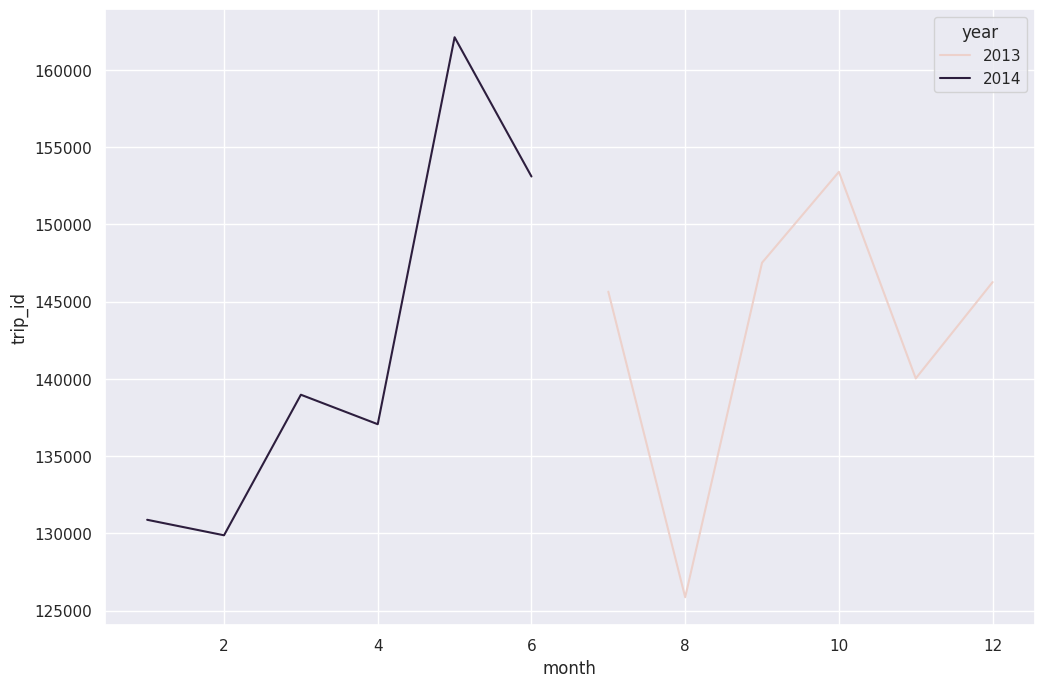

In [17]:
# Visualização Contagem de Viagens por Mese
ax1 = df[['month', 'year', 'trip_id']].groupby(['month','year'] ).count().reset_index()

sns.lineplot(data = ax1, x='month', y='trip_id', hue='year')

<Axes: xlabel='day', ylabel='trip_id'>

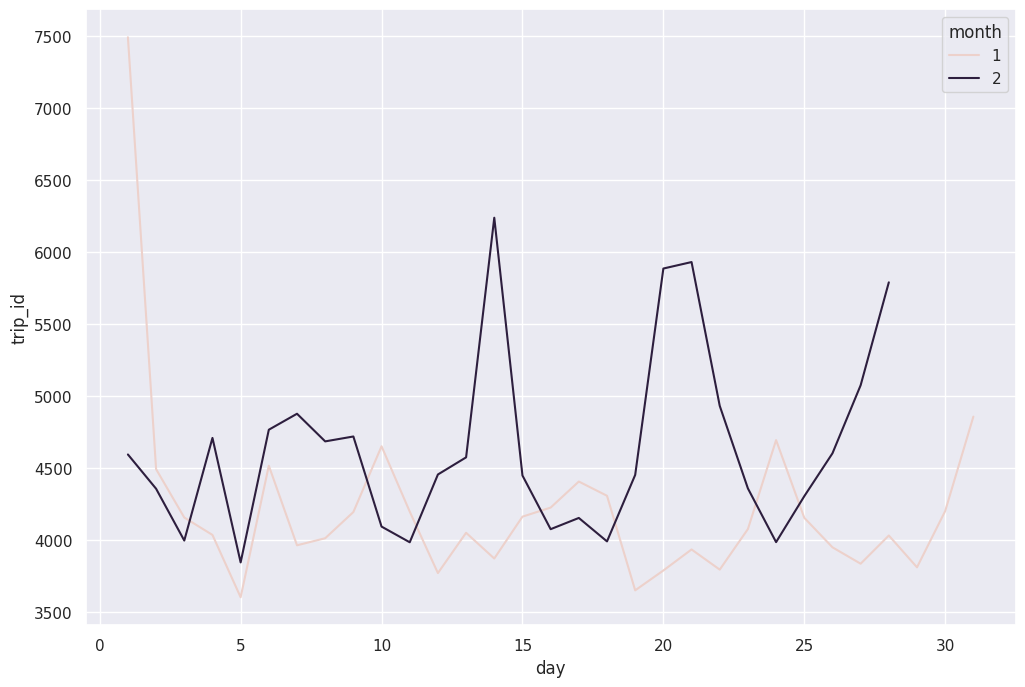

In [18]:
# visualização Contagem de Viagens por Dia nos Meses de Janeiro e Fevereiro
ax1 = df[['month', 'day', 'trip_id']].groupby(['month','day'] ).count().reset_index()
ax2 = ax1[ax1['month'].isin([1,2])]
sns.lineplot(data = ax2, x='day', y='trip_id', hue='month')

<Axes: xlabel='day', ylabel='trip_id'>

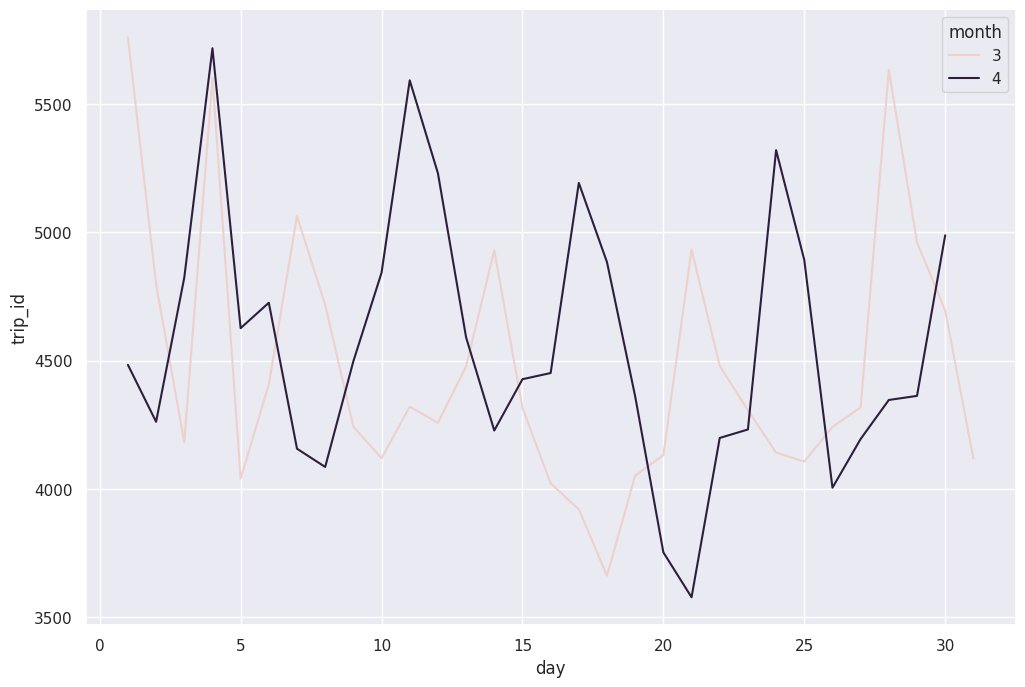

In [19]:
# Contagem de Viagens por Dia nos Meses de Março e Abril
ax2 = ax1[ax1['month'].isin([3,4])]
sns.lineplot(data = ax2, x='day', y='trip_id', hue='month')

<Axes: xlabel='day', ylabel='trip_id'>

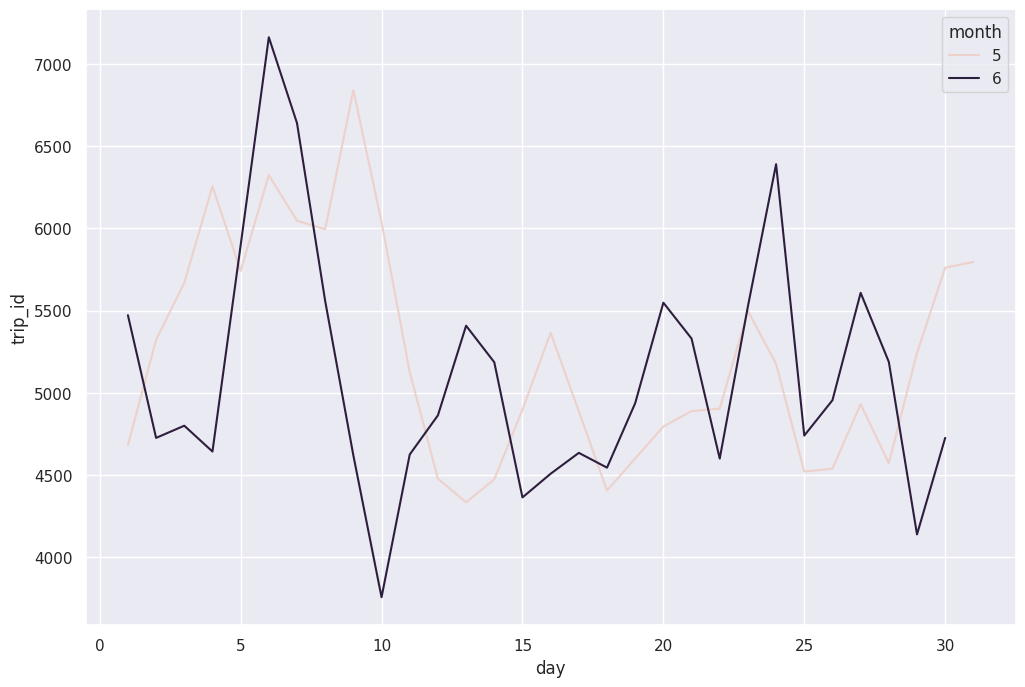

In [20]:
# Contagem de Viagens por Dia nos Meses de Maio e Junho
ax2 = ax1[ax1['month'].isin([5,6])]
sns.lineplot(data = ax2, x='day', y='trip_id', hue='month')

<Axes: xlabel='day', ylabel='trip_id'>

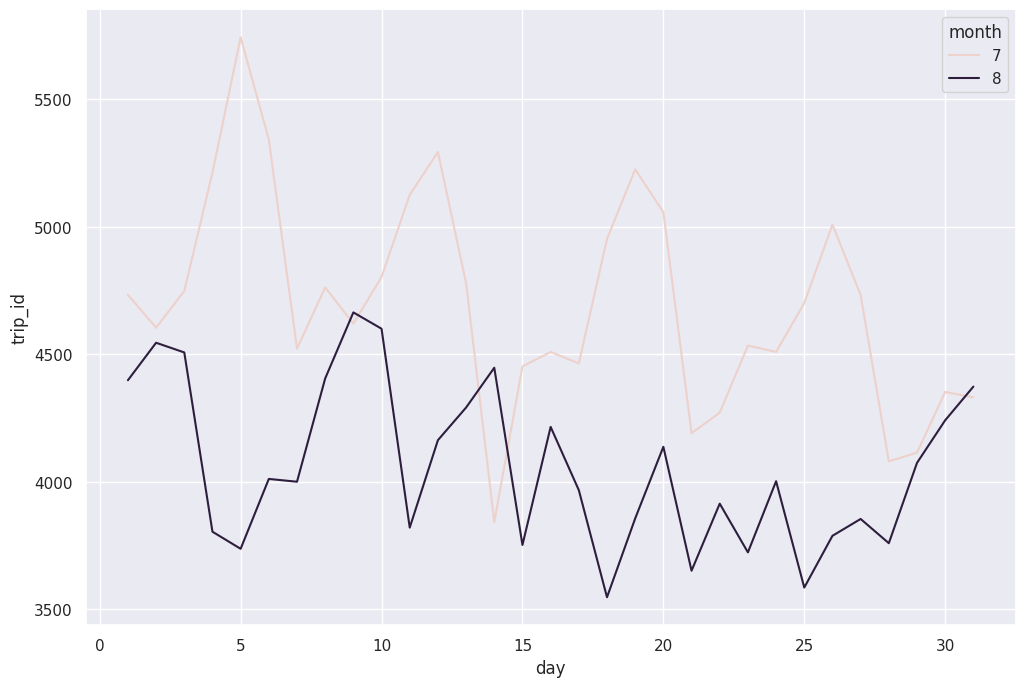

In [21]:
# Contagem de Viagens por Dia nos Meses de Julho e Agosto
ax2 = ax1[ax1['month'].isin([7,8])]
sns.lineplot(data = ax2, x='day', y='trip_id', hue='month')

<Axes: xlabel='day', ylabel='trip_id'>

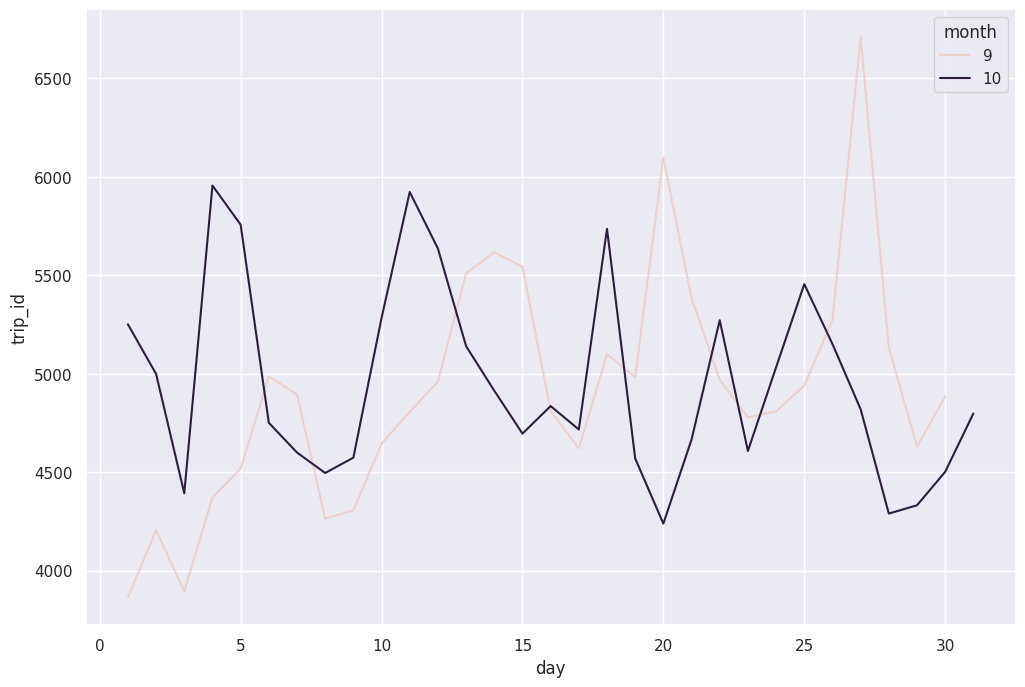

In [22]:
# Contagem de Viagens por Dia nos Meses de Setembro e Outubro
ax2 = ax1[ax1['month'].isin([9,10])]
sns.lineplot(data = ax2, x='day', y='trip_id', hue='month')

<Axes: xlabel='day', ylabel='trip_id'>

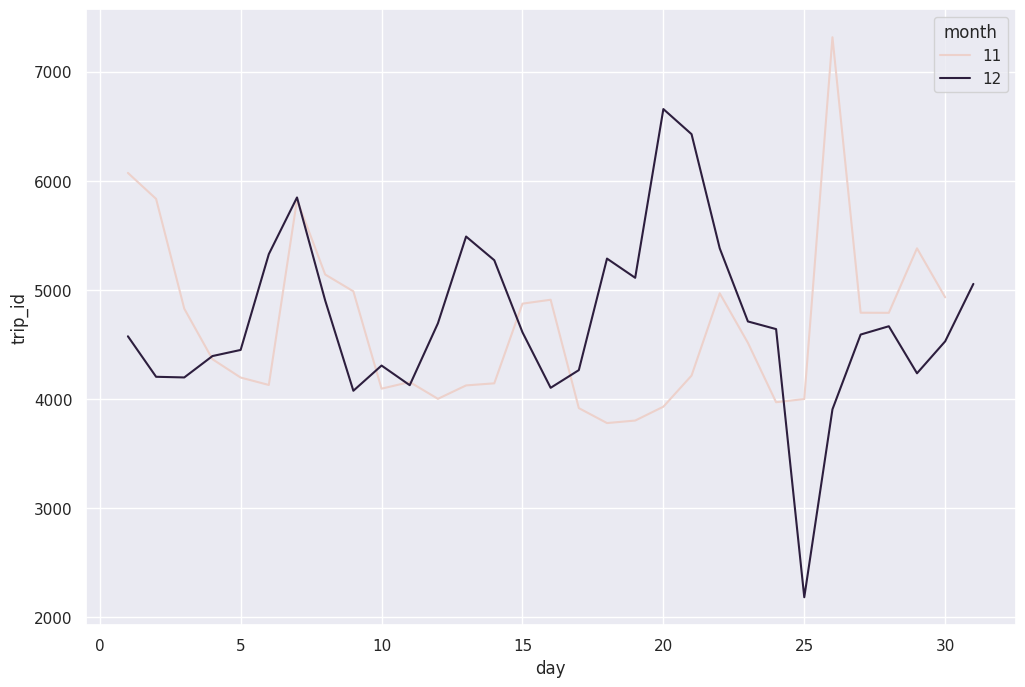

In [23]:
# Contagem de Viagens por Dia nos Meses de Novembro e Dezembro
ax2 = ax1[ax1['month'].isin([11,12])]
sns.lineplot(data = ax2, x='day', y='trip_id', hue='month')

### 3.1.3 Vararivel resposta

In [24]:
# start coordinate and end coordinate
start_lat = 0 
start_long = 1
end_lat = -2
end_long = -1
df["start_lat"] = extract_coordinates(df, start_lat)
df["start_long"] = extract_coordinates(df, start_long)
df["end_lat"] = extract_coordinates(df, end_lat)
df["end_long"] = extract_coordinates(df, end_long)

# Change Data Types
df["start_lat"] = df["start_lat"].astype(float)
df["start_long"] = df["start_long"].astype(float)
df["end_lat"] = df["end_lat"].astype(float)
df["end_long"] = df["end_long"].astype(float)

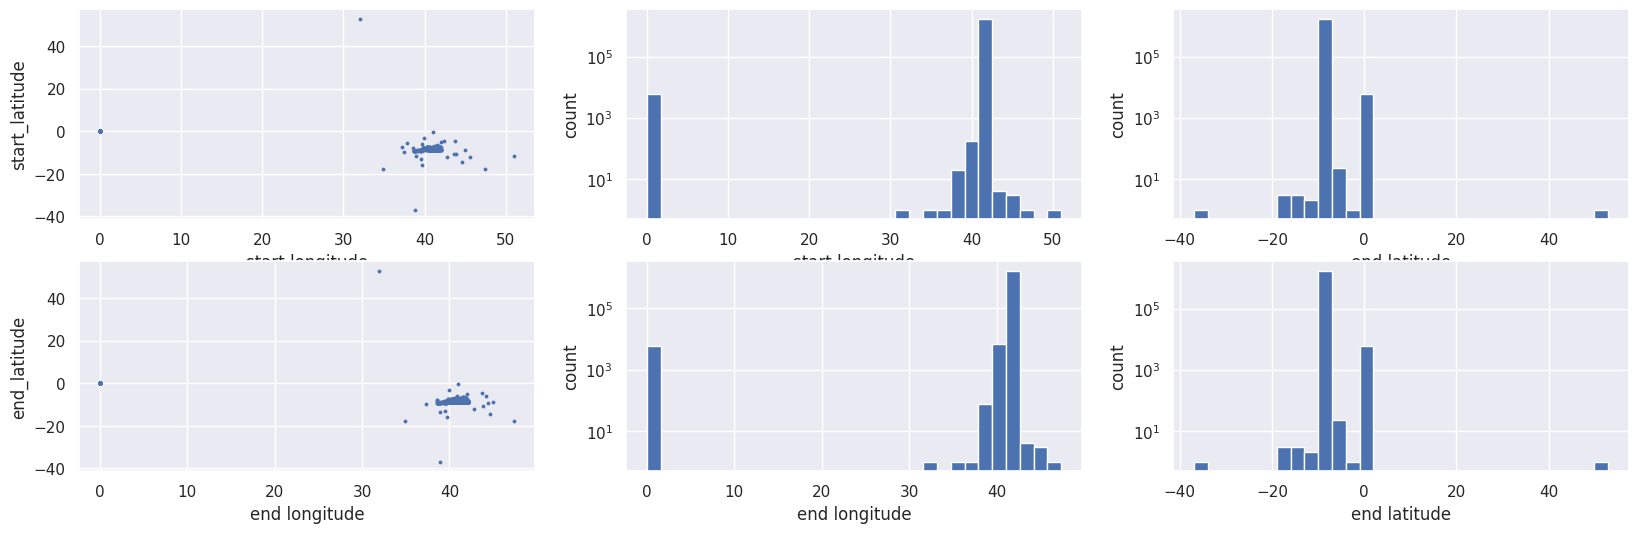

In [25]:
    fig, ax = plt.subplots(2,3,figsize=(20, 6))
    
    # plot
   
    ax[0][0].scatter(df["start_long"], df["start_lat"], s=3)
    ax[0][0].set_xlabel("start longitude")
    ax[0][0].set_ylabel("start_latitude")
    
    # start longitude distribution
    # Visualize the frequency and distribution of "start_long" values.
    ax[0][1].hist(df["start_long"], bins=30)
    ax[0][1].set_xlabel("start longitude")
    ax[0][1].set_ylabel("count")
    ax[0][1].set_yscale("log")
    
    # delta latitude distribution
    # Visualize the frequency and distribution of "start_lat" values.
    ax[0][2].hist(df["end_lat"], bins=30)
    ax[0][2].set_xlabel("end latitude")
    ax[0][2].set_ylabel("count")
    ax[0][2].set_yscale("log")

    
   
    ax[1][0].scatter(df["end_long"], df["end_lat"], s=3)
    ax[1][0].set_xlabel("end longitude")
    ax[1][0].set_ylabel("end_latitude")
    
    # end longitude distribution
    # Visualize the frequency and distribution of "end_long" values.
    ax[1][1].hist(df["end_long"], bins=30)
    ax[1][1].set_xlabel("end longitude")
    ax[1][1].set_ylabel("count")
    ax[1][1].set_yscale("log")
    
    # delta latitude distribution
    # Visualize the frequency and distribution of "end_lat" values.
    ax[1][2].hist(df["end_lat"], bins=30)
    ax[1][2].set_xlabel("end latitude")
    ax[1][2].set_ylabel("count")
    ax[1][2].set_yscale("log")

In [26]:
# Criar um mapa usando folium
aux = df.sample(10)
mymap = folium.Map(location=[aux['start_long'].mean(), aux['start_lat'].mean()], zoom_start=10)
# Adicionar marcadores para o início e o fim de cada trajetória com cores diferentes e numeração
for i, (index, row) in zip(count(start=1), aux.iterrows()):
    start_popup = f'Start: {i}<br>Trip ID: {row["trip_id"]}'
    end_popup = f'End: {i}<br>Trip ID: {row["trip_id"]}'
    
    start_marker = folium.Marker([row['start_long'], row['start_lat']], 
                                    popup=folium.Popup(start_popup, max_width=300),
                                    icon=folium.Icon(color='blue')).add_to(mymap)
    
    end_marker = folium.Marker([row['end_long'], row['end_lat']], 
                                    popup=folium.Popup(start_popup, max_width=300), 
                                    icon=folium.Icon(color='red')).add_to(mymap)
    
    # Converter a string polyline para uma lista de coordenadas e inverter a ordem
    polyline_list = [[coord[1], coord[0]] for coord in ast.literal_eval(row['polyline'])]
    folium.PolyLine(locations=polyline_list, color="blue", weight=2.5, opacity=1).add_to(mymap)

# Adicionar o plugin MarkerCluster para agrupar marcadores
plugins.MarkerCluster().add_to(mymap)

# Exibir o mapa
mymap

## 3.2 Analise Bivariada

In [27]:
df['distance'] = df.apply(lambda row: HaversineDistance(row['start_lat'], 
												  row['start_long'], 
												  row['end_lat'],
												  row['end_long']), axis=1)

### H1: A quantidade de viagens entre o ponto de origem e o ponto de destino (distance) é inferior a 5 km
**Verdadeira**: A quantidade de viagens inferior a 5km é maior

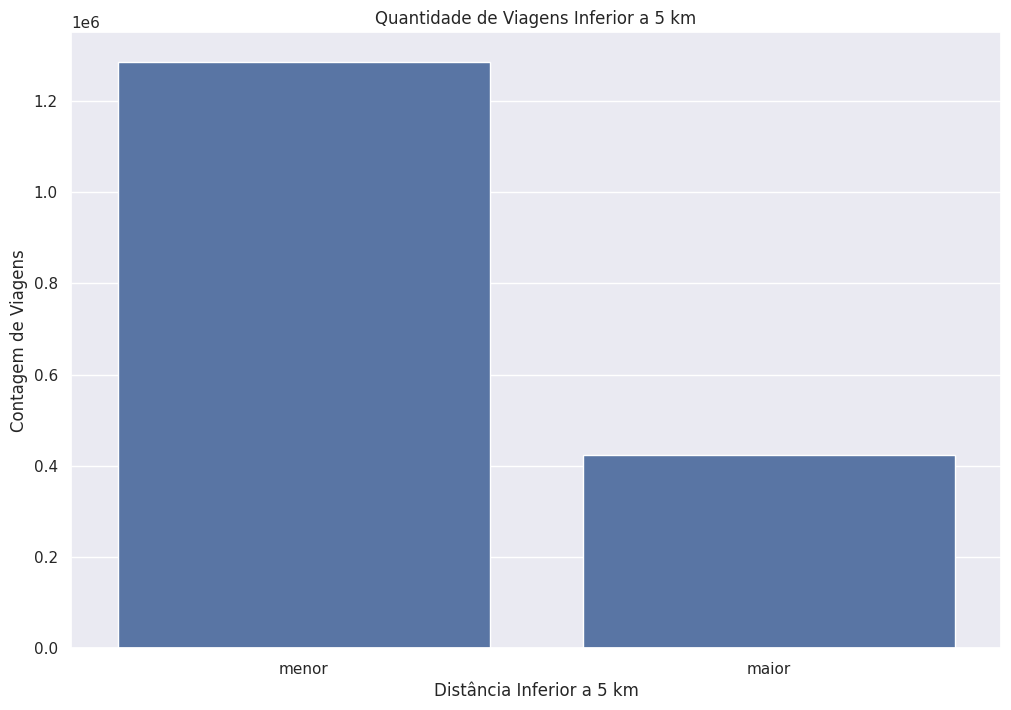

In [28]:
df['distance_5'] = df['distance'].apply(lambda x : 'menor' if x <= 5 else 'maior')

# Plotar um gráfico de barras
sns.countplot(x='distance_5', data=df)
plt.title('Quantidade de Viagens Inferior a 5 km')
plt.xlabel('Distância Inferior a 5 km')
plt.ylabel('Contagem de Viagens')
plt.show()

### H2: A maioria das viagens tem origem em chamadas diretas (call_type 'A').
**Falsa**: A maioria da viagens são do tipo call_type B

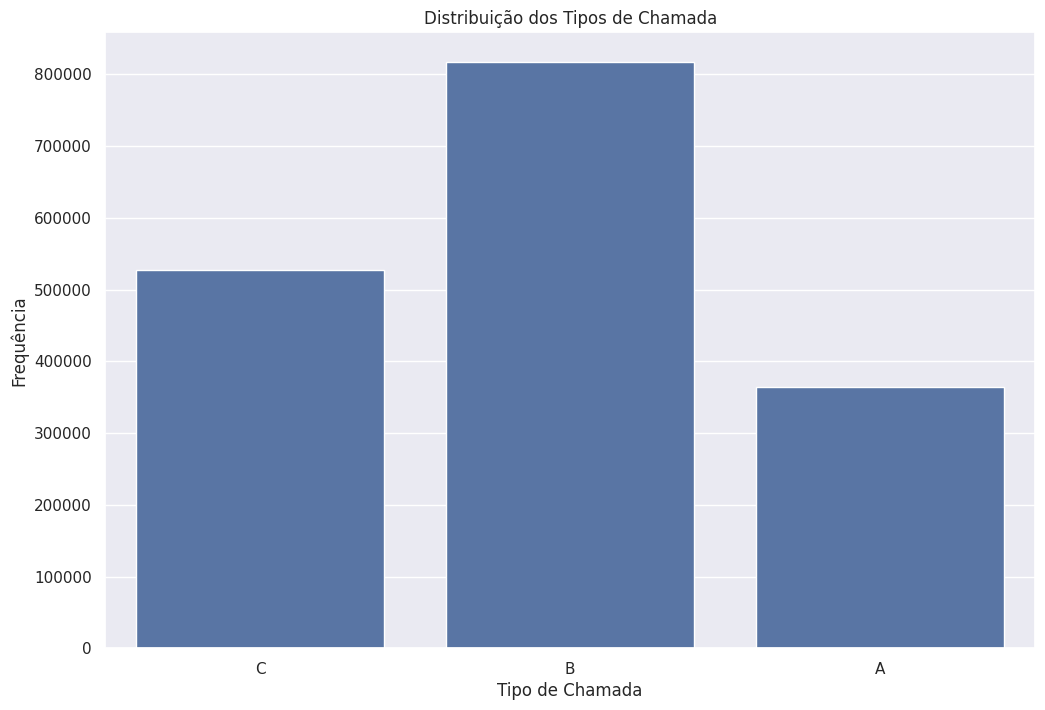

In [29]:
sns.countplot(x='call_type', data=df)
plt.title('Distribuição dos Tipos de Chamada')
plt.xlabel('Tipo de Chamada')
plt.ylabel('Frequência')
plt.show()

### H3: Viagens originadas de chamadas da central (origin_call > 0) têm uma distância média maior do que viagens sem chamadas prévias.
**Falsa**: As viagens de origem na central não interfere na distancia média

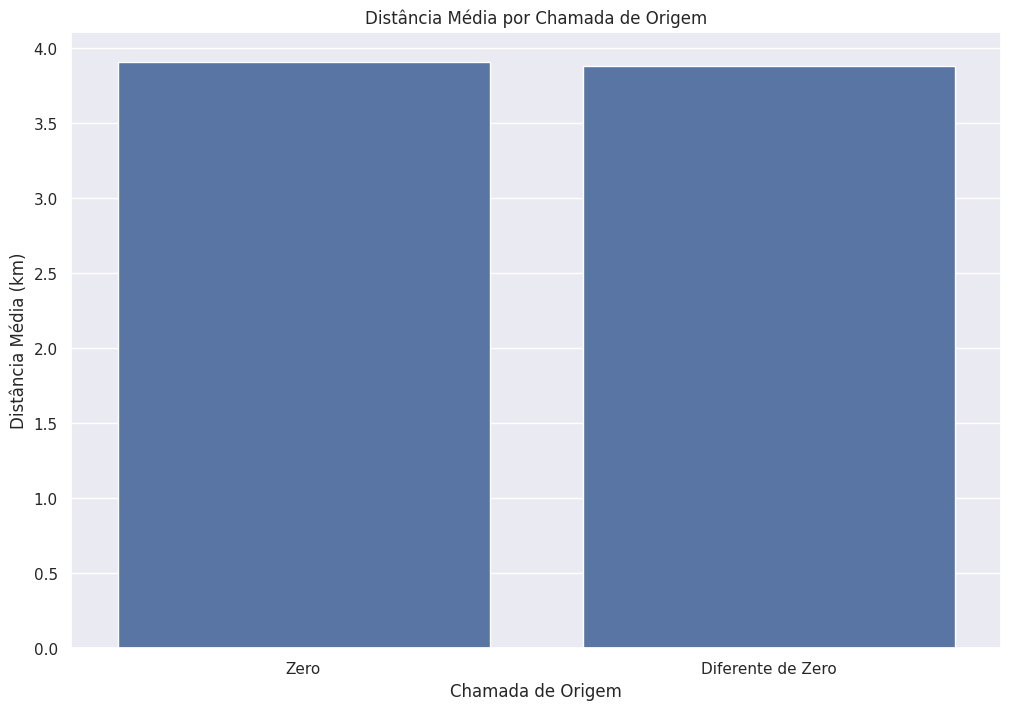

In [30]:
df['origin_call_status'] = df['origin_call'].apply(lambda x: 'Zero' if x == 0 else 'Diferente de Zero')

sns.barplot(x='origin_call_status', y='distance', data=df, ci=None)
plt.title('Distância Média por Chamada de Origem')
plt.xlabel('Chamada de Origem')
plt.ylabel('Distância Média (km)')
plt.show()


### H4: Viagens originadas em stands (origin_stand > 0) têm uma distancia média maior
**Verdadeira**: Apesar da distancia ser pequena a distancia média é maior

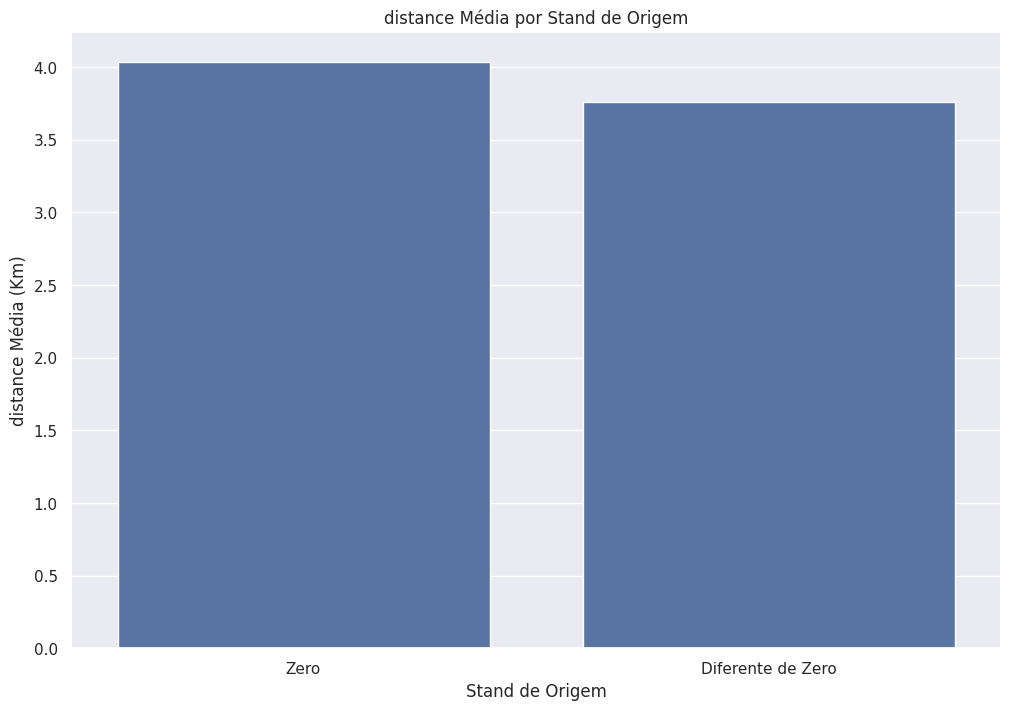

In [31]:
df['origin_stand_status'] = df['origin_stand'].apply(lambda x: 'Zero' if x == 0 else 'Diferente de Zero')

sns.barplot(x='origin_stand_status', y='distance', data=df, ci=None)
plt.title('distance Média por Stand de Origem')
plt.xlabel('Stand de Origem')
plt.ylabel('distance Média (Km)')
plt.show()

### H5: O tipo de chamada ('call_type') influencia na distância média das viagens.
**Verdadeira**: As viagens do tipo C são maiores

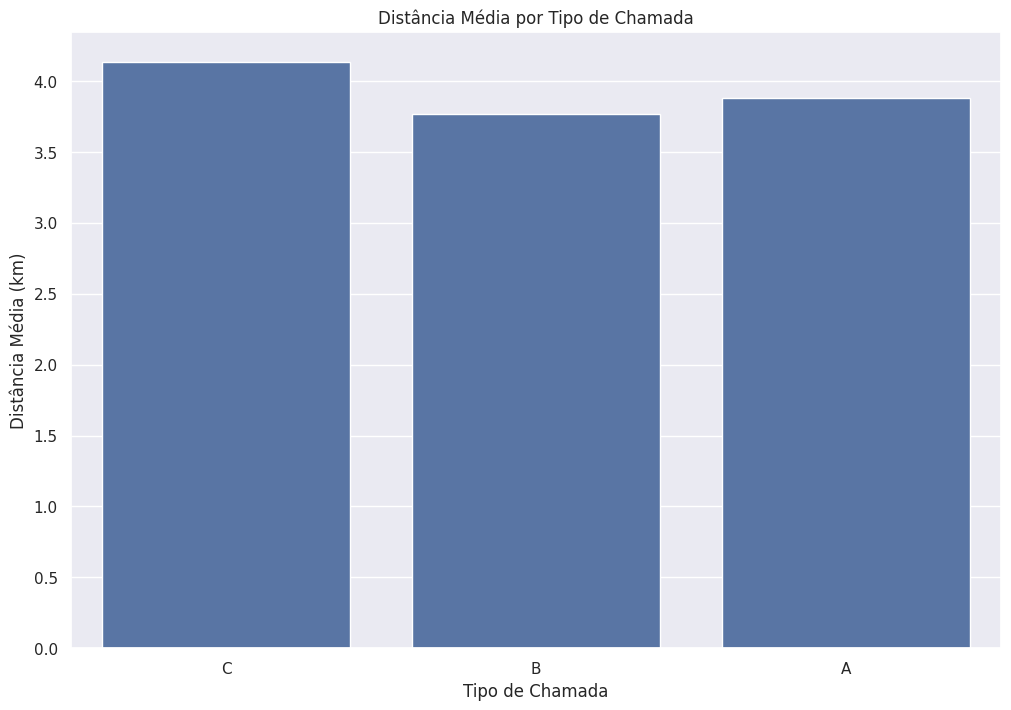

In [32]:
sns.barplot(x='call_type', y='distance', data=df, ci=None)
plt.title('Distância Média por Tipo de Chamada')
plt.xlabel('Tipo de Chamada')
plt.ylabel('Distância Média (km)')
plt.show()

### H6: Viagens em diferentes horários do dia têm Distancia médias diferentes.
**Verdadeira**: As distancias médias nos horarios entre 3 e 7 tem uma distancia média maior 

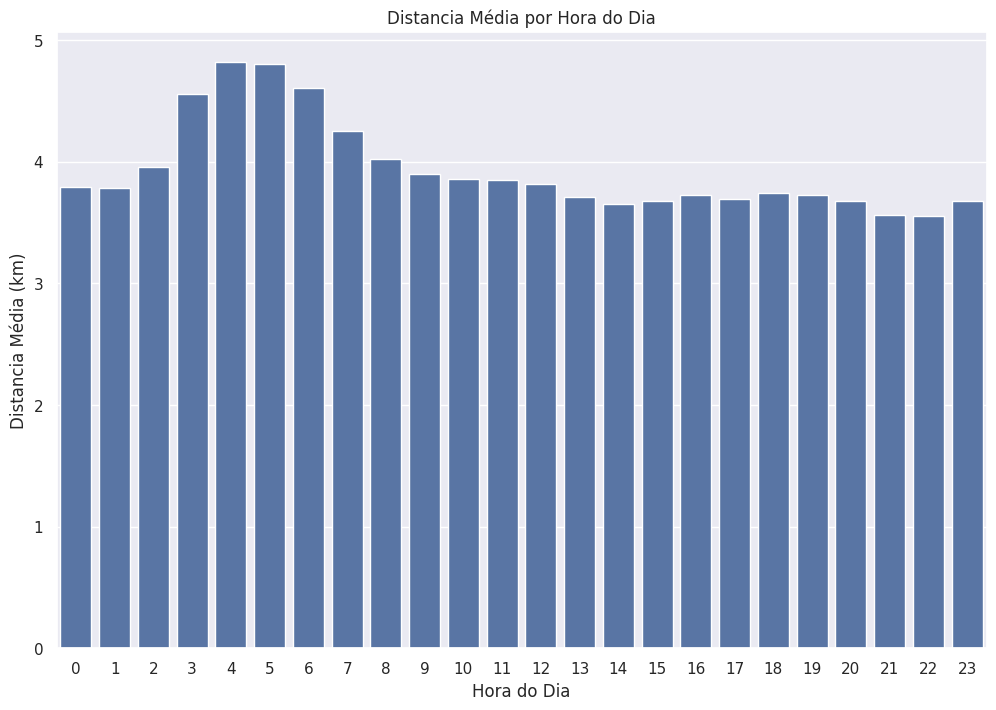

In [33]:
sns.barplot(x='hour', y='distance', data=df, ci=None)
plt.title('Distancia Média por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Distancia Média (km)')
plt.show()

### H7: Viagens em dias de semana (weekday) têm uma distância média igual das viagens nos finais de semana.
**Falsa**: A distancia média no domingo é maior

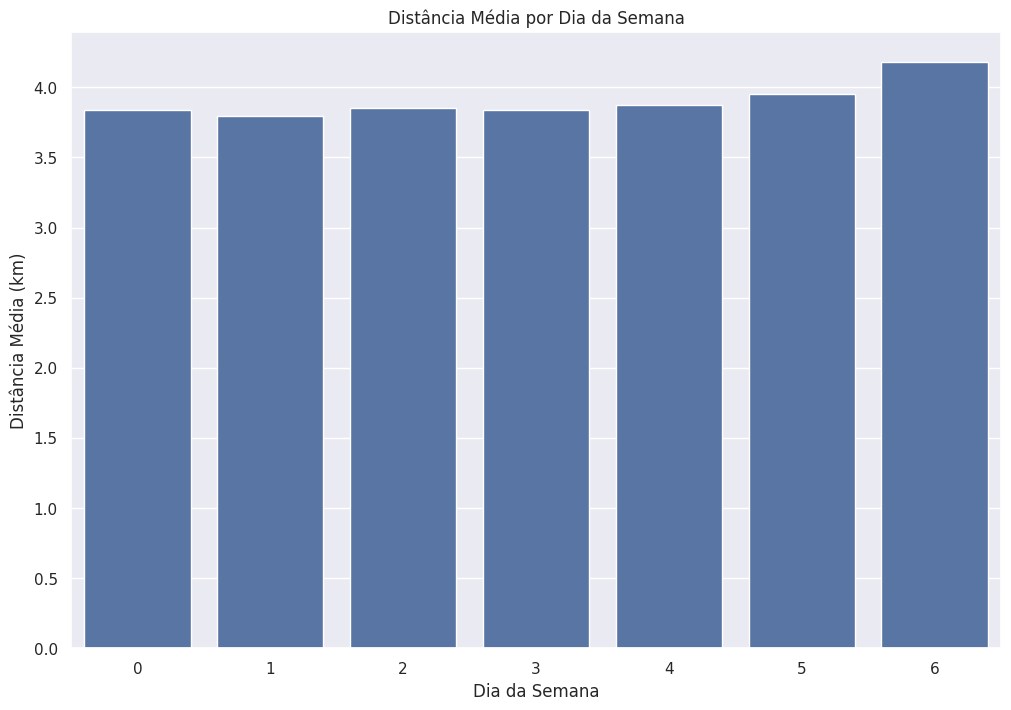

In [34]:
sns.barplot(x='weekday', y='distance', data=df, ci=None)
plt.title('Distância Média por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Distância Média (km)')
plt.show()

### H8: Viagens durante o dia têm uma duração média diferente das viagens durante a noite.
**Falsa**: As viagens durante a noite tem uma média maior

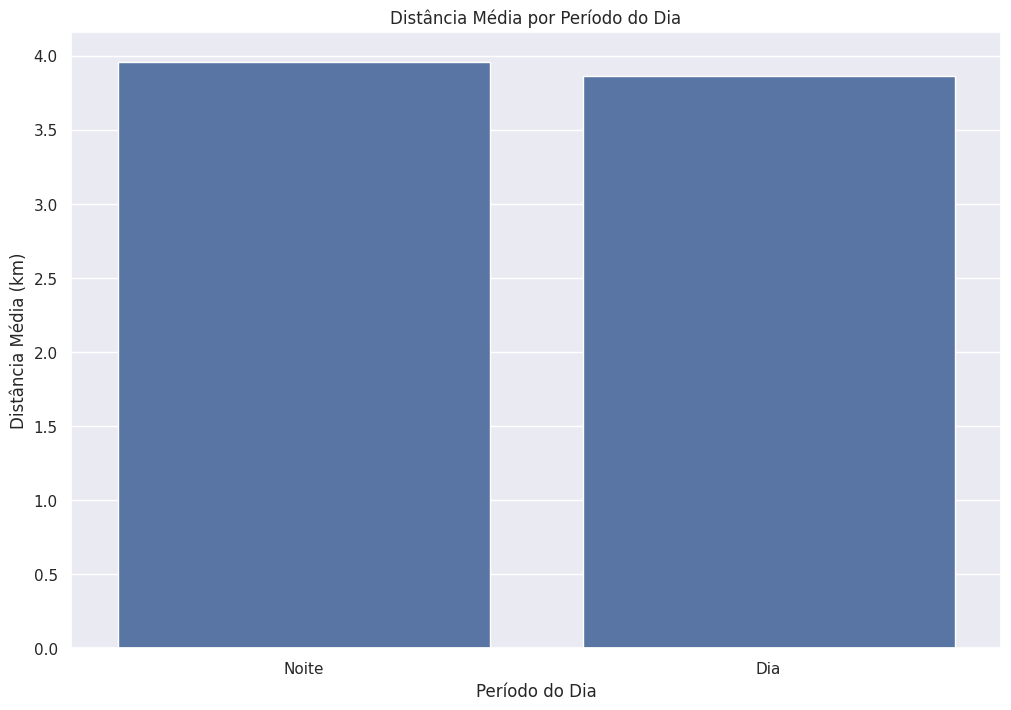

In [35]:
df['day_night'] = df['hour'].apply(lambda x: 'Dia' if 6 <= x < 18 else 'Noite')
sns.barplot(x='day_night', y='distance', data=df, ci=None)
plt.title('Distância Média por Período do Dia')
plt.xlabel('Período do Dia')
plt.ylabel('Distância Média (km)')
plt.show()

### H9: O tipo de chamada ('call_type') influencia na distância média das viagens ao longo dos meses.
**False** O tipo de chamada durante os meses sempre ficam na ordem C > B > A

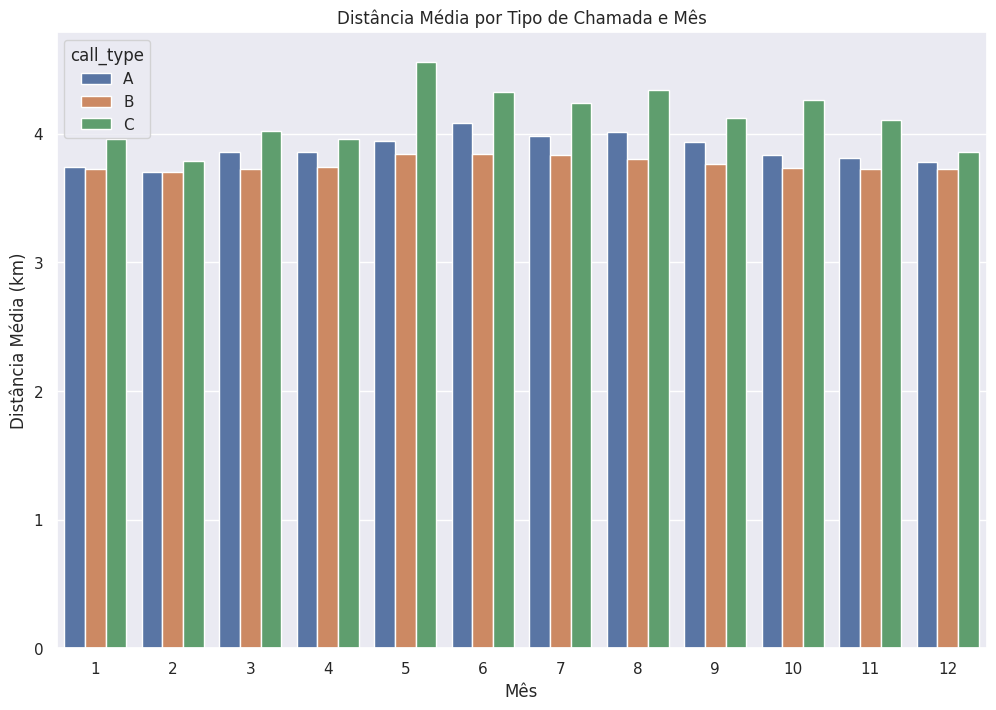

In [36]:
sns.barplot(x='month', y='distance', hue='call_type', data=df, ci=None)
plt.title('Distância Média por Tipo de Chamada e Mês')
plt.xlabel('Mês')
plt.ylabel('Distância Média (km)')
plt.show()

## 3.3 Analise Multivariada

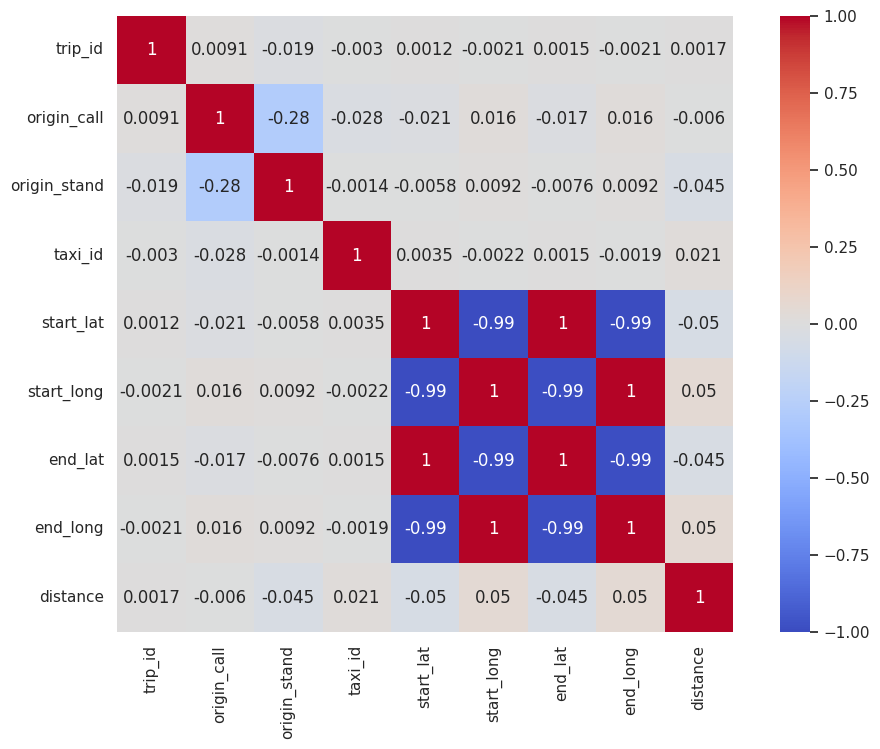

In [37]:
num_attributes = df.select_dtypes( include = ['int64', 'float64'] )
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True);

# 5.0 Data Preprocessing

In [38]:
# Delete lon & lat have "0"
df = df.loc[df['polyline'] != '[]']

# DROPPING "DAY_TYPE" COLUMN
df.drop(columns="day_type", inplace=True)

In [39]:
df["missing_data"] = df.apply(miss_flg, axis=1)

In [40]:
call_type_dic = {"A":1, "B":2, "C":3}
df["call_type"] = df["call_type"].map(call_type_dic)

In [41]:
df.to_csv(os.path.join(home, 'data', 'data_preprocessing.csv') , index=False)

In [51]:
df = pd.read_csv(os.path.join(home, 'data', 'data_preprocessing.csv'))

In [52]:
#df = df.sample(1_000_000)

# 6.0 Machine Learning Model

In [53]:
X = df[["call_type",'origin_call','origin_stand', 'missing_data', 'start_lat', 'start_long']]
y = df[['end_lat', 'end_long']]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## 6.1 Linear regresson

In [55]:
lr = LinearRegression(n_jobs=1)

result_lr = fit_model(lr, X_train, X_test, y_train, y_test)
result_lr


,Model Name,Erro testing RMSE,Erro Teste MSE,distance
0,LinearRegression,0.040294,0.001653,3.662085


## 6.2 Random Forest

In [56]:
florest = RandomForestRegressor(n_estimators=100, random_state=1)

result_florest = fit_model(florest, X_train, X_test, y_train, y_test)
result_florest

,Model Name,Erro testing RMSE,Erro Teste MSE,distance
0,RandomForestRegressor,0.063924,0.004776,2.395322


## 6.3 GRADIENT BOOSTING REGRESSOR MODEL

In [57]:
bosting = GradientBoostingRegressor(random_state=0)

result_bosting = fit_model(bosting, X_train, X_test, y_train, y_test)
result_bosting

,Model Name,Erro testing RMSE,Erro Teste MSE,distance
0,GradientBoostingRegressor,0.061597,0.004483,3.554149


## 6.4 KNEIGHBORS REGRESSOR MODEL

In [58]:
knn = KNeighborsRegressor()

result_knn = fit_model(knn, X_train, X_test, y_train, y_test)
result_knn

,Model Name,Erro testing RMSE,Erro Teste MSE,distance
0,KNeighborsRegressor,0.065896,0.005082,3.319768


## 6.5 DECISIONTREE REGRESSOR MODEL

In [59]:
dt = DecisionTreeRegressor(max_depth=50, random_state=1)

result_dt = fit_model(dt, X_train, X_test, y_train, y_test)
result_dt

,Model Name,Erro testing RMSE,Erro Teste MSE,distance
0,DecisionTreeRegressor,0.068467,0.005178,1.790473


## 6.6. Compare Model's Performance

In [60]:
modelling_result = pd.concat( [result_lr, result_florest, result_bosting, result_knn, result_dt] )
modelling_result

,Model Name,Erro testing RMSE,Erro Teste MSE,distance
0,LinearRegression,0.040294,0.001653,3.662085
0,RandomForestRegressor,0.063924,0.004776,2.395322
0,GradientBoostingRegressor,0.061597,0.004483,3.554149
0,KNeighborsRegressor,0.065896,0.005082,3.319768
0,DecisionTreeRegressor,0.068467,0.005178,1.790473


# 7.0 Deploy do modelo

## 7.1 Taxi class

In [1]:
import os
import pickle

import inflection
import pandas as pd



class taxi(object):
    def __init__(self):
        self.home_path = os.path.dirname(os.getcwd())
        self.parameter_path = os.path.join(self.home_path, 'paremeter')

    def data_cleaning(self,df):

        # Renomear colunas
        cols_old = list(df.columns)

        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        df.columns = cols_new

        df = df[['call_type','origin_call','origin_stand', 'missing_data','timestamp', 'polyline']].copy()

        # Substituir valores NAN por 0
        df['origin_call'] = df['origin_call'].fillna(0)
        df['origin_stand'] = df['origin_stand'].fillna(0)

        # Alterar tipos de dados
        df['origin_call'] = df['origin_call'].astype(int)
        df['origin_stand'] = df['origin_stand'].astype(int)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

        return df

    def feature_engineering(self, df):

        # Criar as coodenadas latitude e logitude
        start_lat = 0 
        start_long = 1
        end_lat = -2
        end_long = -1
        df["start_lat"] = self.extract_coordinates(df, start_lat)
        df["start_long"] = self.extract_coordinates(df, start_long)
        df["end_lat"] = self.extract_coordinates(df, end_lat)
        df["end_long"] = self.extract_coordinates(df, end_long)

        # Alterar os tipos de dados
        df["start_lat"] = df["start_lat"].astype(float)
        df["start_long"] = df["start_long"].astype(float)
        df["end_lat"] = df["end_lat"].astype(float)
        df["end_long"] = df["end_long"].astype(float)


        return df[["call_type",'origin_call','origin_stand', 'missing_data', 'start_lat', 'start_long']].copy()

    def extract_coordinates(self, df, coord):

        lista=list()
        for i in range(0,len(df["polyline"])):
            if df["polyline"][i] == '[]':
                ax=0

            else:
                ax = df["polyline"][i].split(',')[coord].strip('[]')

            lista.append(ax)

        return lista


    def data_preparation(self, df):
        df["missing_data"] = df.apply(self.miss_flg, axis=1)

        call_type_dic = {"A":1, "B":2, "C":3}
        df["call_type"] = df["call_type"].map(call_type_dic)
        return df

    def miss_flg(self, df):
        return 1 if df["missing_data"] else 0

    def get_prediction(self, model, teste_data):
        pred = model.predict(teste_data)
        return pred

In [2]:
home = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(home, 'data', 'test.csv'))
model_pah = os.path.join(home, 'model', 'GradientBoostingRegressor.pkl')
model = pickle.load(open(model_pah, 'rb'))

In [3]:
taxi = taxi()
df1 = taxi.data_cleaning(df)
df2 = taxi.feature_engineering(df1)
df3 = taxi.data_preparation(df2)
df4 = taxi.get_prediction(model, df3)

df[['pred_lat', 'pred_long']] = df4
df

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,pred_lat,pred_long
0,T1,B,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",-8.615154,41.163353
1,T2,B,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",-8.620621,41.157193
2,T3,B,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",-8.615154,41.163353
3,T4,B,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",-8.621271,41.156268
4,T5,B,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",-8.621415,41.159144
...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False,"[[-8.570196,41.159484],[-8.570187,41.158962],[...",-8.595673,41.162047
316,T324,B,NaN,53.0,20000020,1419170802,A,False,"[[-8.613873,41.141232],[-8.613882,41.141241],[...",-8.621271,41.156268
317,T325,C,NaN,NaN,20000207,1419172121,A,False,"[[-8.6481,41.152536],[-8.647461,41.15241],[-8....",-8.631567,41.161914
318,T326,A,76232.0,NaN,20000667,1419171980,A,False,"[[-8.571699,41.156073],[-8.570583,41.155929],[...",-8.597889,41.161321


## 7.2 API Handler

In [4]:
import pickle
import pandas as pd
from flask import Flask, request, Response

from taxi import taxi

# loading model
home = os.path.dirname(os.getcwd())
model_pah = os.path.join(home, 'model', 'GradientBoostingRegressor.pkl')
model = pickle.load(open(model_pah, 'rb'))

#inicialize API
app = Flask(__name__)

@app.route('/taxi/predict', methods=['GET'])
def taxi_predict():
    teste_json = request.get_json()

    if teste_json: # there is data
        if isinstance(teste_json, dict): # unique example 
            test_raw = pd.DataFrame(teste_json, index=[0])
        
        else: # multiple example
            test_raw = pd.DataFrame(teste_json, columns=teste_json[0].keys())

        # Instantiate Rossmann class
        pipeline = taxi()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        features_array = df3.values.reshape(-1, df3.shape[1])

        # prediction
        df4 = pipeline.get_prediction(model, features_array)
        return df4

    else:
        return Response('{}', status=200, mimetype='application/json')
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 7.3 API Tester

In [10]:
import requests
import json
import pandas as pd
import os

In [19]:
home = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(home, 'data', 'test.csv'))
# convert DataFrame to json
data = json.dumps(df.to_dict(orient='records'))

In [21]:
# API Call
url = 'http://0.0.0.0:5000/taxi/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.get(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [22]:
data = pd.DataFrame(r.json(), columns=r.json()[0].keys())
data

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,pred_lat,pred_long
0,T1,B,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...",-8.615154,41.163353
1,T2,B,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...",-8.620621,41.157193
2,T3,B,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...",-8.615154,41.163353
3,T4,B,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...",-8.621271,41.156268
4,T5,B,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]",-8.621415,41.159144
...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False,"[[-8.570196,41.159484],[-8.570187,41.158962],[...",-8.595673,41.162047
316,T324,B,NaN,53.0,20000020,1419170802,A,False,"[[-8.613873,41.141232],[-8.613882,41.141241],[...",-8.621271,41.156268
317,T325,C,NaN,NaN,20000207,1419172121,A,False,"[[-8.6481,41.152536],[-8.647461,41.15241],[-8....",-8.631567,41.161914
318,T326,A,76232.0,NaN,20000667,1419171980,A,False,"[[-8.571699,41.156073],[-8.570583,41.155929],[...",-8.597889,41.161321
